# MODELO

In [ ]:
!wget --no-check-certificate https://storage.googleapis.com/platzi-tf2/MalariaCells.zip \
    -O /tmp/MalariaCells.zip

--2024-02-08 13:21:24--  https://storage.googleapis.com/platzi-tf2/MalariaCells.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.128.207, 142.251.6.207, 172.217.212.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.128.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 547750600 (522M) [application/zip]
Saving to: ‘/tmp/MalariaCells.zip’

/tmp/MalariaCells.z 100%[===================>] 522.38M   159MB/s    in 3.3s    

2024-02-08 13:21:28 (159 MB/s) - ‘/tmp/MalariaCells.zip’ saved [547750600/547750600]



In [ ]:
import os
import zipfile

In [ ]:
local_zip = "/tmp/MalariaCells.zip"
zip_ref = zipfile.ZipFile(local_zip, "r")
zip_ref.extractall("/tmp/MalariaCells")
zip_ref.close()

In [ ]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import string
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers

In [ ]:
train_dir = "/tmp/MalariaCells/Train"
test_dir = "/tmp/MalariaCells/Test"

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1/255)
test_datagen = ImageDataGenerator(rescale = 1/255, validation_split = 0.2)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (96, 96),
    batch_size = 64,
    class_mode = "categorical",
    color_mode = "grayscale",
    subset = "training"
)

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (96, 96),
    batch_size = 64,
    class_mode = "categorical",
    color_mode = "grayscale",
    subset = "validation"
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (96, 96),
    batch_size = 64,
    class_mode = "categorical",
    color_mode = "grayscale"
)

In [ ]:
classes = ["Parasitized", "Uninfected"]

In [ ]:
def plotImages(images_arr):
  fig, axes = plt.subplots(1, 6, figsize = (10, 10))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img[:,:,0])
    ax.axis("off")
  plt.tight_layout()
  plt.show()

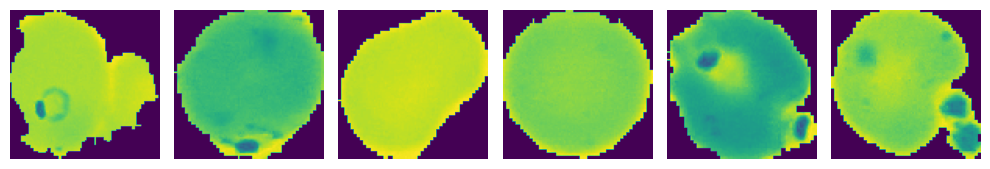

In [ ]:
sample_training_images, _= next(train_generator)
plotImages(sample_training_images[:6])

ARQUITECTURA DE LA NN

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(75, (3,3),input_shape = (124,124,1) ),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, kernel_regularizer = regularizers.l2(1e-5), activation = "relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, kernel_regularizer = regularizers.l2(1e-5), activation = "relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(classes), activation = "softmax")
])

In [ ]:
model.summary()

In [ ]:
early_callback = tf.keras.callbacks.EarlyStopping(monitor = "loss", patience = 3, mode = "auto")

In [ ]:
model.compile(optimizer= "adam", loss= "categorical_crossentropy", metrics = ["accuracy"])

history = model.fit(
    train_generator,
    epochs = 50,
    callbacks = [early_callback],
    validation_data = validation_generator
)

In [ ]:
results = model.evaluate(test_generator)

124/124 [==============================] - 19s 156ms/step - loss: 0.2798 - accuracy: 0.9250


In [ ]:
def visualizacion_resultados(history):
    # Recuperar la precisión y la pérdida del objeto history
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']


    # Crear un rango de épocas para el eje x
    epochs = range(1, len(acc) + 1)

    # Plotear la precisión
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, "go-", label='Training accuracy')
    plt.plot(epochs, val_acc, "ro-", label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.legend()

    # Plotear la pérdida
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'go-', label='Training loss')
    plt.plot(epochs, val_loss, "ro-", label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()

    # Mostrar los gráficos
    plt.show()

# Tu código para compilar y entrenar el modelo aquí...

# Llamar a la función de visualización
visualizacion_resultados(history)

In [ ]:
import cv2

def Predecir(image_path):

  img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
  img_resized = cv2.resize(img, (124, 124))
  img_resized = np.expand_dims(img_resized, axis=-1)
  img_resized = np.expand_dims(img_resized, axis=0)
  img_resized = img_resized / 255.0

  print("Prob: Parasitized| Uninfected")
  return model.predict(img_resized)


In [ ]:
Predecir("/tmp/MalariaCells/Test/Uninfected/C100P61ThinF_IMG_20150918_145938_cell_67.png")

Prob: Parasitized| Uninfected
1/1 [==============================] - 0s 17ms/step


array([[0.01682789, 0.98317206]], dtype=float32)

# MODELO AUTO-TUNNER

In [ ]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import string
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers

In [ ]:
!pip install -q -U keras-tuner
import kerastuner as kt
from tensorflow import keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.5 MB/s eta 0:00:00


<ipython-input-3-0703c731f7cf>:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [ ]:
classes = ["Parasitized", "Uninfected"]

In [ ]:
def constructor_modelo(hp):

  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Conv2D(75,(3,3), activation = "relu", input_shape = (96,96,1)))
  model.add(tf.keras.layers.MaxPool2D((2,2)))
  model.add(tf.keras.layers.Flatten())

  hp_units = hp.Int("units", min_value = 32, max_value = 512, step = 32)
  model.add(tf.keras.layers.Dense(units = hp_units, activation = "relu", kernel_regularizer = regularizers.l2(1e-5)))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(128, activation = "relu", kernel_regularizer = regularizers.l2(1e-5)))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(len(classes), activation = "softmax"))

  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])

  model.compile(optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate),loss = "categorical_crossentropy", metrics = ["accuracy"])

  return model


In [ ]:
tuner = kt.Hyperband(
    constructor_modelo,
    objective = "val_accuracy",
    max_epochs = 20,
    factor = 3,
    directory = "models/",
    project_name = "platzi-tunner"
)

Reloading Tuner from models/platzi-tunner/tuner0.json


In [ ]:
tuner.search(train_generator, epochs =20, validation_data = validation_generator)

best_hps = tuner.get_best_hyperparameters(num_trials =1)[0]

Trial 28 Complete [00h 15m 30s]
val_accuracy: 0.9933670163154602

Best val_accuracy So Far: 0.9993683099746704
Total elapsed time: 02h 27m 27s


In [ ]:
print(best_hps.get("units"))

448


In [ ]:
print(best_hps.get("learning_rate"))

0.0001


In [ ]:
early_callback = tf.keras.callbacks.EarlyStopping(monitor = "loss", patience = 3, mode = "auto")

In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)

history_hipermodel = hypermodel.fit(
    train_generator,
    epochs = 20,
    callbacks = [early_callback],
    validation_data = validation_generator
)

Epoch 1/20
431/431 [==============================] - 43s 95ms/step - loss: 0.6795 - accuracy: 0.5841 - val_loss: 0.5876 - val_accuracy: 0.7202
Epoch 2/20
431/431 [==============================] - 41s 94ms/step - loss: 0.5898 - accuracy: 0.6938 - val_loss: 0.5211 - val_accuracy: 0.7650
Epoch 3/20
431/431 [==============================] - 42s 98ms/step - loss: 0.5340 - accuracy: 0.7420 - val_loss: 0.4638 - val_accuracy: 0.8001
Epoch 4/20
431/431 [==============================] - 40s 94ms/step - loss: 0.4669 - accuracy: 0.7884 - val_loss: 0.3784 - val_accuracy: 0.8648
Epoch 5/20
431/431 [==============================] - 40s 94ms/step - loss: 0.4083 - accuracy: 0.8243 - val_loss: 0.3288 - val_accuracy: 0.8790
Epoch 6/20
431/431 [==============================] - 40s 94ms/step - loss: 0.3460 - accuracy: 0.8576 - val_loss: 0.2728 - val_accuracy: 0.9100
Epoch 7/20
431/431 [==============================] - 41s 94ms/step - loss: 0.2983 - accuracy: 0.8837 - val_loss: 0.2485 - val_accuracy:

In [ ]:
hypermodel.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 94, 94, 75)        750       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 47, 47, 75)        0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 165675)            0         
                                                                 
 dense_9 (Dense)             (None, 448)               74222848  
                                                                 
 dropout_6 (Dropout)         (None, 448)               0         
                                                                 
 dense_10 (Dense)            (None, 128)               57472     
                                                      

GUARDAR, CARGAR, DESCARGAR MODELO

In [ ]:
config_arquitect_dict = hypermodel.get_config()

In [ ]:
print(config_arquitect_dict)

{'name': 'sequential_3', 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 96, 96, 1), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'conv2d_3_input'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_3', 'trainable': True, 'dtype': 'float32', 'batch_input_shape': (None, 96, 96, 1), 'filters': 75, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_

CARGAR ARQUITECTURA

In [ ]:
config_arquitect_dict ={'name': 'sequential_3', 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 96, 96, 1), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'conv2d_3_input'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_3', 'trainable': True, 'dtype': 'float32', 'batch_input_shape': (None, 96, 96, 1), 'filters': 75, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': (None, 96, 96, 1)}}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'max_pooling2d_3', 'trainable': True, 'dtype': 'float32', 'pool_size': (2, 2), 'padding': 'valid', 'strides': (2, 2), 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': (None, 94, 94, 75)}}, {'module': 'keras.layers', 'class_name': 'Flatten', 'config': {'name': 'flatten_3', 'trainable': True, 'dtype': 'float32', 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': (None, 47, 47, 75)}}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_9', 'trainable': True, 'dtype': 'float32', 'units': 448, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': {'module': 'keras.regularizers', 'class_name': 'L2', 'config': {'l2': 9.999999747378752e-06}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': (None, 165675)}}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_6', 'trainable': True, 'dtype': 'float32', 'rate': 0.2, 'noise_shape': None, 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': (None, 448)}}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_10', 'trainable': True, 'dtype': 'float32', 'units': 128, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': {'module': 'keras.regularizers', 'class_name': 'L2', 'config': {'l2': 9.999999747378752e-06}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': (None, 448)}}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_7', 'trainable': True, 'dtype': 'float32', 'rate': 0.2, 'noise_shape': None, 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': (None, 128)}}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_11', 'trainable': True, 'dtype': 'float32', 'units': 2, 'activation': 'softmax', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': (None, 128)}}]}

In [ ]:
model_same_config = tf.keras.Sequential.from_config(config_arquitect_dict)
model_same_config.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 94, 94, 75)        750       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 47, 47, 75)        0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 165675)            0         
                                                                 
 dense_9 (Dense)             (None, 448)               74222848  
                                                                 
 dropout_6 (Dropout)         (None, 448)               0         
                                                                 
 dense_10 (Dense)            (None, 128)               57472     
                                                      